In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go #importing graphical objects

import chart_studio.plotly as py 

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from geopy import geocoders as gn

import networkx as nx

# Where Do All of the Venture Dollars Go?

## The Location Relationship between Venture Capital and Startup Funding

By: Mackenzie Lobato, CSCI 4502






### Object Information

This dataframe comprises all basic company, financial organization, and person information. It includes the total amount of funding raised, the funding series, and additional summary information.

In [2]:
objects=pd.read_csv("updated_objects.csv", low_memory=False)
objects.head()

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,0,0,2005-10-01,2008-05-19,3,39750000,2010-09-05,2013-09-18,5,17
1,c:1001,Company,1001,NaN,FriendFeed,friendfeed,/company/friendfeed,web,acquired,2007-10-01,...,0,0,2008-02-26,2008-02-26,1,5000000,2008-05-01,2012-09-13,3,14
2,c:10014,Company,10014,NaN,Mobclix,mobclix,/company/mobclix,mobile,acquired,2008-03-01,...,0,0,2008-09-01,2008-09-01,1,0,1995-03-01,2012-09-18,4,9
3,c:10015,Company,10015,NaN,Fitbit,fitbit,/company/fitbit,health,operating,2007-10-01,...,0,0,2008-10-10,2013-08-13,5,68069200,NaN,NaN,0,14
4,c:100155,Company,100155,NaN,MTPV,mtpv,/company/mtpv,cleantech,operating,2003-01-01,...,0,0,2011-03-08,2012-01-26,3,10125293,2010-01-01,2010-01-01,1,6


In [3]:
objects['entity_type'].value_counts()


Company         32270
FinancialOrg     7270
Person           6494
Name: entity_type, dtype: int64

In [4]:
objects.drop(["homepage_url", "twitter_username", "logo_url","logo_width","logo_height", 
              "short_description", "description", "overview", "tag_list", "milestones", 
              "permalink", "first_milestone_at", "last_milestone_at", "name"], 1,inplace=True)

In [5]:
objects.head()

,id,entity_type,entity_id,parent_id,normalized_name,category_code,status,founded_at,closed_at,domain,...,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships
0,c:1,Company,1,NaN,wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,...,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3,39750000,17
1,c:1001,Company,1001,NaN,friendfeed,web,acquired,2007-10-01,NaN,friendfeed.com,...,SF Bay,NaN,NaN,0,0,2008-02-26,2008-02-26,1,5000000,14
2,c:10014,Company,10014,NaN,mobclix,mobile,acquired,2008-03-01,NaN,mobclix.com,...,SF Bay,NaN,NaN,0,0,2008-09-01,2008-09-01,1,0,9
3,c:10015,Company,10015,NaN,fitbit,health,operating,2007-10-01,NaN,fitbit.com,...,SF Bay,NaN,NaN,0,0,2008-10-10,2013-08-13,5,68069200,14
4,c:100155,Company,100155,NaN,mtpv,cleantech,operating,2003-01-01,NaN,mtpv.com,...,Austin,NaN,NaN,0,0,2011-03-08,2012-01-26,3,10125293,6


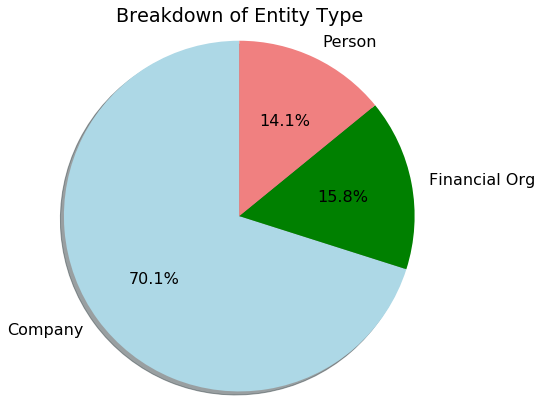

In [6]:
objects['entity_type'].value_counts()

plt.rcParams['figure.figsize'] = (7,7)
plt.rcParams['font.size'] = 16

#plot who is in this data
labels = 'Company', 'Financial Org', 'Person'
sizes=[32270,7270,6494]
colors=['lightblue','green','lightcoral']

plt.pie(sizes,labels=labels,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Breakdown of Entity Type')

plt.axis('equal')
plt.show()

Figure 1. This is the breakdown of objects in the object dataframe, how many companies, financial organizations, and persons are in the data set.

In [7]:
objects_filtered = objects[objects['entity_type'] == 'Company'] 
objects_filtered['status'].value_counts()

operating    27261
acquired      2500
closed        1905
ipo            604
Name: status, dtype: int64

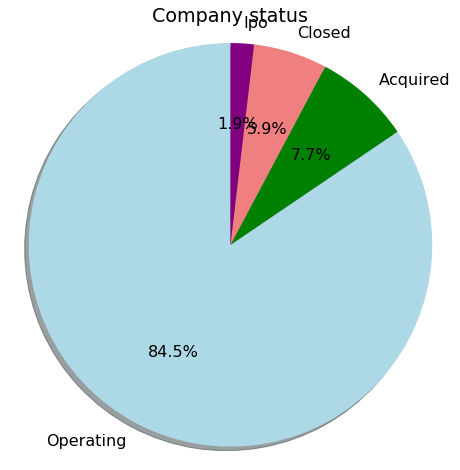

In [8]:
plt.rcParams['figure.figsize'] = (8,8)
plt.rcParams['font.size'] = 16


#plot operating status
labels = 'Operating', 'Acquired', 'Closed','Ipo'
sizes=[27261,2500,1905,604]
colors=['lightblue','green','lightcoral','purple']

plt.pie(sizes,labels=labels,colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('Company status')

plt.axis('equal')
plt.show()

Figure 2. This is the snapshot of operating status' of the companies at this moment.

In [9]:
#Renames objects in order to be merged and broken down properly in sections below.
objects.rename(columns={'id':'funded_object_id'}, inplace=True)
objects.head()

,funded_object_id,entity_type,entity_id,parent_id,normalized_name,category_code,status,founded_at,closed_at,domain,...,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships
0,c:1,Company,1,NaN,wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,...,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3,39750000,17
1,c:1001,Company,1001,NaN,friendfeed,web,acquired,2007-10-01,NaN,friendfeed.com,...,SF Bay,NaN,NaN,0,0,2008-02-26,2008-02-26,1,5000000,14
2,c:10014,Company,10014,NaN,mobclix,mobile,acquired,2008-03-01,NaN,mobclix.com,...,SF Bay,NaN,NaN,0,0,2008-09-01,2008-09-01,1,0,9
3,c:10015,Company,10015,NaN,fitbit,health,operating,2007-10-01,NaN,fitbit.com,...,SF Bay,NaN,NaN,0,0,2008-10-10,2013-08-13,5,68069200,14
4,c:100155,Company,100155,NaN,mtpv,cleantech,operating,2003-01-01,NaN,mtpv.com,...,Austin,NaN,NaN,0,0,2011-03-08,2012-01-26,3,10125293,6


### Fund Information

Here, there is fund specific information include how large the fund is, the name of the fund and when it was raised. These are fund specific and not neccessarily specific firms names.

In [10]:
#Import Fund information
funds=pd.read_csv("updated_funds.csv", low_memory=False)
#funds.head()

In [11]:
funds.drop(["source_url","source_description"],1,inplace=True)

In [12]:
funds.head()

,id,fund_id,object_id,name,funded_at,raised_amount,raised_currency_code
0,1,1,f:371,Second Fund,2008-12-16,300000000,USD
1,4,4,f:17,Sequoia Israel Fourth Fund,2008-12-17,200750000,USD
2,5,5,f:951,Tenth fund,2008-08-11,650000000,USD
3,6,6,f:192,New funds acquire,NaN,625000000,USD
4,7,7,f:519,Third fund,2008-05-20,200000000,USD


In [13]:
funds.rename(columns={'object_id':'investor_object_id'}, inplace=True)
funds.head()

,id,fund_id,investor_object_id,name,funded_at,raised_amount,raised_currency_code
0,1,1,f:371,Second Fund,2008-12-16,300000000,USD
1,4,4,f:17,Sequoia Israel Fourth Fund,2008-12-17,200750000,USD
2,5,5,f:951,Tenth fund,2008-08-11,650000000,USD
3,6,6,f:192,New funds acquire,NaN,625000000,USD
4,7,7,f:519,Third fund,2008-05-20,200000000,USD


In [14]:
duplicate_funds = funds.copy()
duplicate_funds.head()

,id,fund_id,investor_object_id,name,funded_at,raised_amount,raised_currency_code
0,1,1,f:371,Second Fund,2008-12-16,300000000,USD
1,4,4,f:17,Sequoia Israel Fourth Fund,2008-12-17,200750000,USD
2,5,5,f:951,Tenth fund,2008-08-11,650000000,USD
3,6,6,f:192,New funds acquire,NaN,625000000,USD
4,7,7,f:519,Third fund,2008-05-20,200000000,USD


### Funding Round Information

This is the breakdown of funding of the company entities in the original objects file. This gives more specific information about the funding round (EX: Company X raised Y amount in M funding series (series-a, series-b, seed, angel, etc.)) 

In [15]:
#Importing all of the individual fund rounds of companies

funding_rounds=pd.read_csv("updated_funding_rounds.csv", low_memory=False)
#funding_rounds.head()

In [16]:
funding_rounds.drop(["source_url","source_description","is_first_round", "is_last_round",
                     "pre_money_valuation_usd", "pre_money_valuation","pre_money_currency_code",
                     "post_money_valuation_usd", "post_money_valuation", "post_money_currency_code"],1,inplace=True)

In [17]:
funding_rounds.head()

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,participants
0,1,1,c:4,2006-12-01,series-b,b,8500000,8500000,USD,2
1,2,2,c:5,2004-09-01,angel,angel,500000,500000,USD,2
2,3,3,c:5,2005-05-01,series-a,a,12700000,12700000,USD,3
3,4,4,c:5,2006-04-01,series-b,b,27500000,27500000,USD,4
4,5,5,c:7299,2006-05-01,series-b,b,10500000,10500000,USD,2


### Investment Information

This section is the most important for my hypothesis. The investment info helps to create the relationships between files. These relationships are what drive the location information at the bottom of this section.

In [18]:
#Importing investment informations, this is the primary csv to merge relationships between funds and companies.

investments=pd.read_csv("updated_investments.csv", low_memory=False)
investments.head()

,id,funding_round_id,funded_object_id,investor_object_id
0,1,1,c:4,f:1
1,2,1,c:4,f:2
2,3,3,c:5,f:4
3,4,4,c:5,f:1
4,5,4,c:5,f:5


#### Merging investments and objects to begin creating relationship between investor and company

In [19]:
# This merge focuses on the the funded object id in order to retain all of the company information 

IR = investments.merge(objects,on='funded_object_id')
IR.head()

,id,funding_round_id,funded_object_id,investor_object_id,entity_type,entity_id,parent_id,normalized_name,category_code,status,...,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships
0,8,5,c:7299,f:3,Company,7299,NaN,photobucket,web,acquired,...,Denver,2009-12-16,2009-12-16,1,1,2005-03-01,2013-05-14,7,33672656,35
1,127,77,c:7299,f:47,Company,7299,NaN,photobucket,web,acquired,...,Denver,2009-12-16,2009-12-16,1,1,2005-03-01,2013-05-14,7,33672656,35
2,7050,5098,c:7299,f:648,Company,7299,NaN,photobucket,web,acquired,...,Denver,2009-12-16,2009-12-16,1,1,2005-03-01,2013-05-14,7,33672656,35
3,7051,5098,c:7299,f:249,Company,7299,NaN,photobucket,web,acquired,...,Denver,2009-12-16,2009-12-16,1,1,2005-03-01,2013-05-14,7,33672656,35
4,7052,5098,c:7299,f:851,Company,7299,NaN,photobucket,web,acquired,...,Denver,2009-12-16,2009-12-16,1,1,2005-03-01,2013-05-14,7,33672656,35


#### Filtering Investments for those in the USA

In [20]:
IR_filtered = IR[IR['country_code'] == 'USA'] 
  
# Print the new dataframe 
IR_filtered.head(15) 
IR_filtered['country_code'].value_counts()

# The output is the total amount of connections between fund and 
#investment and it's why it's so much larger than the original data set

USA    54300
Name: country_code, dtype: int64

In [21]:
#IR.dtypes

In [22]:
#This code merges the investments data frame and funds data frame to retain the investor information

IF = IR_filtered.merge(funds,on='investor_object_id')
IF.head()

,id_x,funding_round_id,funded_object_id,investor_object_id,entity_type,entity_id,parent_id,normalized_name,category_code,status,...,last_funding_at,funding_rounds,funding_total_usd,relationships,id_y,fund_id,name,funded_at,raised_amount,raised_currency_code
0,127,77,c:7299,f:47,Company,7299,NaN,photobucket,web,acquired,...,2013-05-14,7,33672656,35,440,440,Insight Venture Partners VII,2011-04-04,1570000000,USD
1,127,77,c:7299,f:47,Company,7299,NaN,photobucket,web,acquired,...,2013-05-14,7,33672656,35,441,441,Insight Venture Partners Coinvestment Fund II,2011-04-04,450000000,USD
2,127,77,c:7299,f:47,Company,7299,NaN,photobucket,web,acquired,...,2013-05-14,7,33672656,35,1161,1161,Insight Venture Partners VIII,2013-05-29,2570000000,USD
3,13050,8775,c:12,f:47,Company,12,NaN,twitter,social,ipo,...,2011-09-08,8,1160166511,162,440,440,Insight Venture Partners VII,2011-04-04,1570000000,USD
4,13050,8775,c:12,f:47,Company,12,NaN,twitter,social,ipo,...,2011-09-08,8,1160166511,162,441,441,Insight Venture Partners Coinvestment Fund II,2011-04-04,450000000,USD


### Filtered Data

This section helps to filter the data by country, and by industry. I created this section in order to model how connected different industries and funds can be. This trend is modeled in the network graphs below and shows that no matter what industry a startup is in, there is always a set of funds that continue to invest in the same network of companies and very few companies that solely rely on one or two investors to raise money.

In [23]:
IF_filtered = IF[IF['country_code'] == 'USA'] 
  
# Print the new dataframe 
IF_filtered.head(15) 
IF_filtered['country_code'].value_counts()

IF_filtered_web = IF_filtered[IF_filtered['category_code'] == 'web'] 
  
# Print the new dataframe 
IF_filtered_web.head(15) 
IF_filtered_web['country_code'].value_counts()

IF_filtered_med = IF_filtered[IF_filtered['category_code'] == 'med'] 
  
# Print the new dataframe 
IF_filtered_med.head(15) 
IF_filtered_med['country_code'].value_counts()

IF_filtered_transportation = IF_filtered[IF_filtered['category_code'] == 'transportation'] 
IF_filtered_transportation.head(15) 
IF_filtered_transportation['country_code'].value_counts()

USA    129
Name: country_code, dtype: int64

In [24]:
IF_filtered['country_code'].value_counts()

USA    52443
Name: country_code, dtype: int64

In [25]:
IF_filtered_transportation['region'].value_counts()

SF Bay                   67
Los Angeles              21
Austin                   13
Greenville                9
NW Atlanta                8
United States - Other     6
Albuquerque               2
Washington DC             2
Phoenix                   1
Name: region, dtype: int64

/Users/mackenize.lobato/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning:


The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.



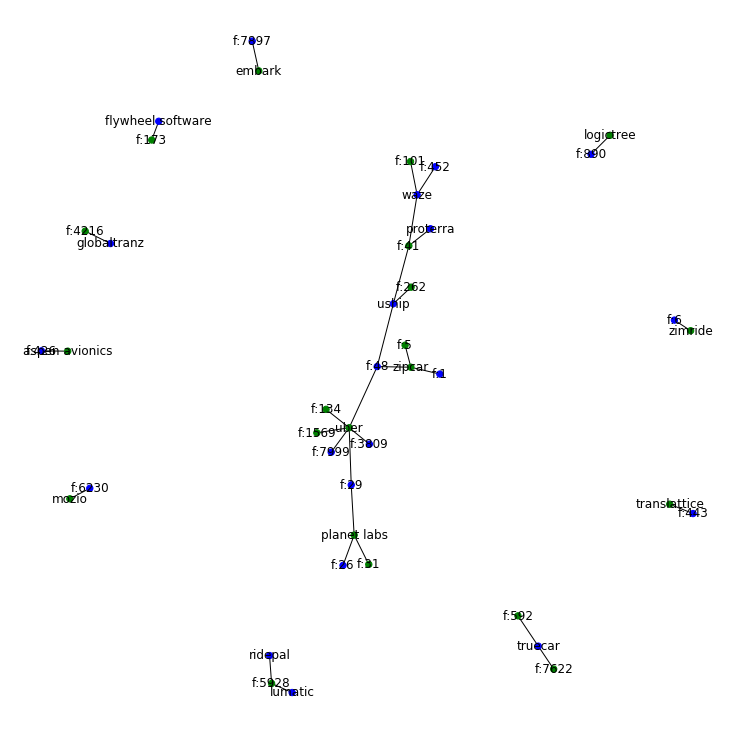

In [44]:
from matplotlib.pyplot import figure
        
G = nx.Graph()

G = nx.from_pandas_edgelist(IF_filtered_transportation,'normalized_name','investor_object_id')

colors = ['g','b']*21
figure(figsize=(10, 10))

nx.draw(G, prog = 'fdp',with_labels=True, node_size = 40, node_color=colors)

Figure 3. This figure models the connections in the transportation industry specifically with green nodes representing the startup and blue nodes representing the financial fund.

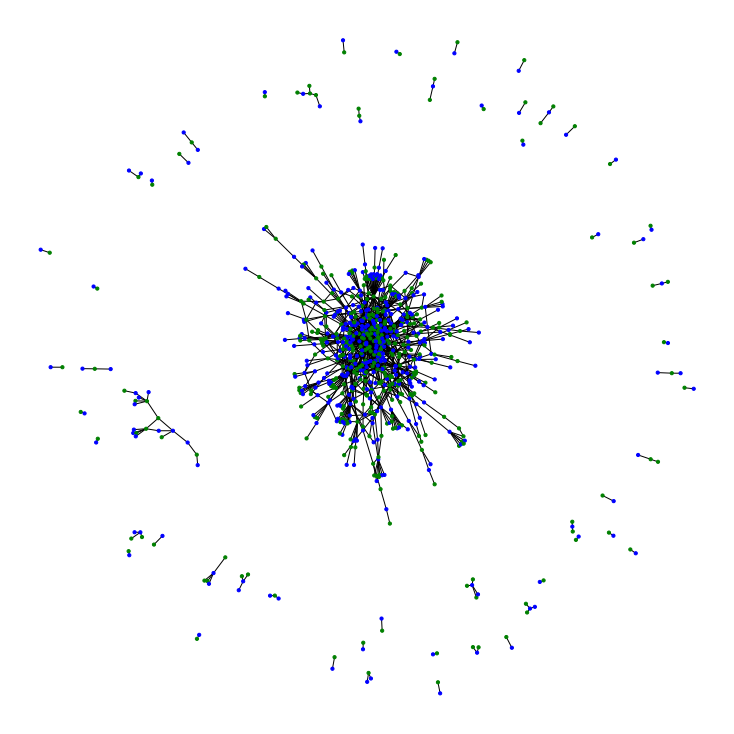

In [27]:
from matplotlib.pyplot import figure

        
G = nx.Graph()

G = nx.from_pandas_edgelist(IF_filtered_web,'normalized_name','investor_object_id')

colors = ['g','b']*399
figure(figsize=(10, 10))
nx.draw(G,prog="fdp", with_labels=False, node_size = 10, node_color = colors)

Figure 4. This figure models the connections in the web industry specifically with green nodes representing the startup and blue nodes representing the financial fund.

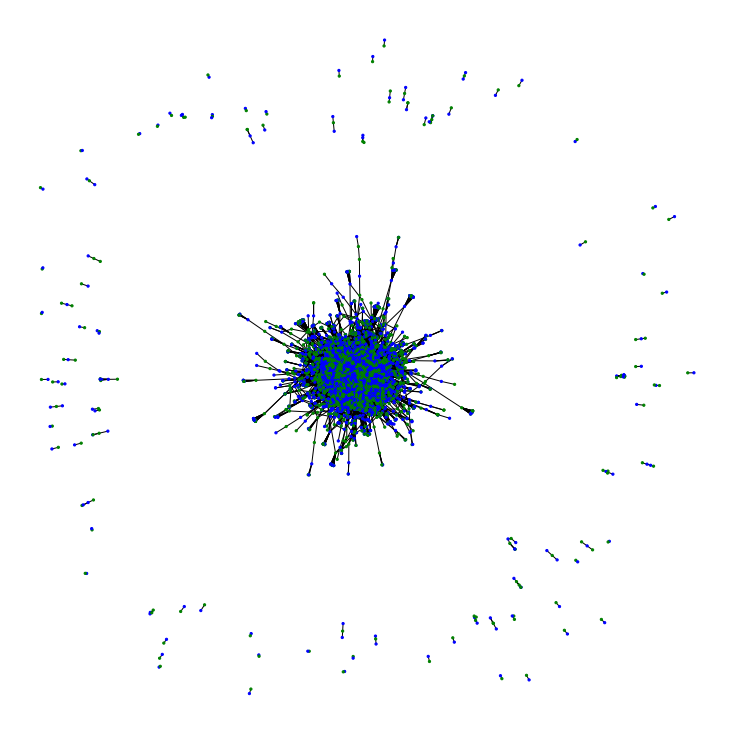

In [28]:
from matplotlib.pyplot import figure
       
G = nx.Graph()

G = nx.from_pandas_edgelist(IF_filtered,'normalized_name','investor_object_id')

colors = ['g','b']*3637


figure(figsize=(10, 10))
nx.draw(G,prog="fdp", with_labels=False, node_size = 5, node_color = colors)

Figure 5. This figure models the connections in the entire US startup industry industry specifically with green nodes representing the startup and blue nodes representing the financial fund.

In [29]:
IF_filtered['category_code'].value_counts()

software            7257
enterprise          5293
web                 4215
biotech             4100
mobile              3872
advertising         3661
ecommerce           2204
games_video         2053
cleantech           2009
analytics           1933
hardware            1603
semiconductor       1494
security            1255
network_hosting     1030
medical             1008
finance              953
social               762
education            754
health               731
search               638
messaging            504
public_relations     499
other                496
fashion              462
news                 416
manufacturing        311
hospitality          295
travel               265
nanotech             229
music                228
photo_video          208
real_estate          187
consulting           147
transportation       129
automotive           107
legal                 82
nonprofit             80
sports                54
pets                  54
local                 40


#### This graph shows the amount of each type of company raising money, organized by greatest to least.

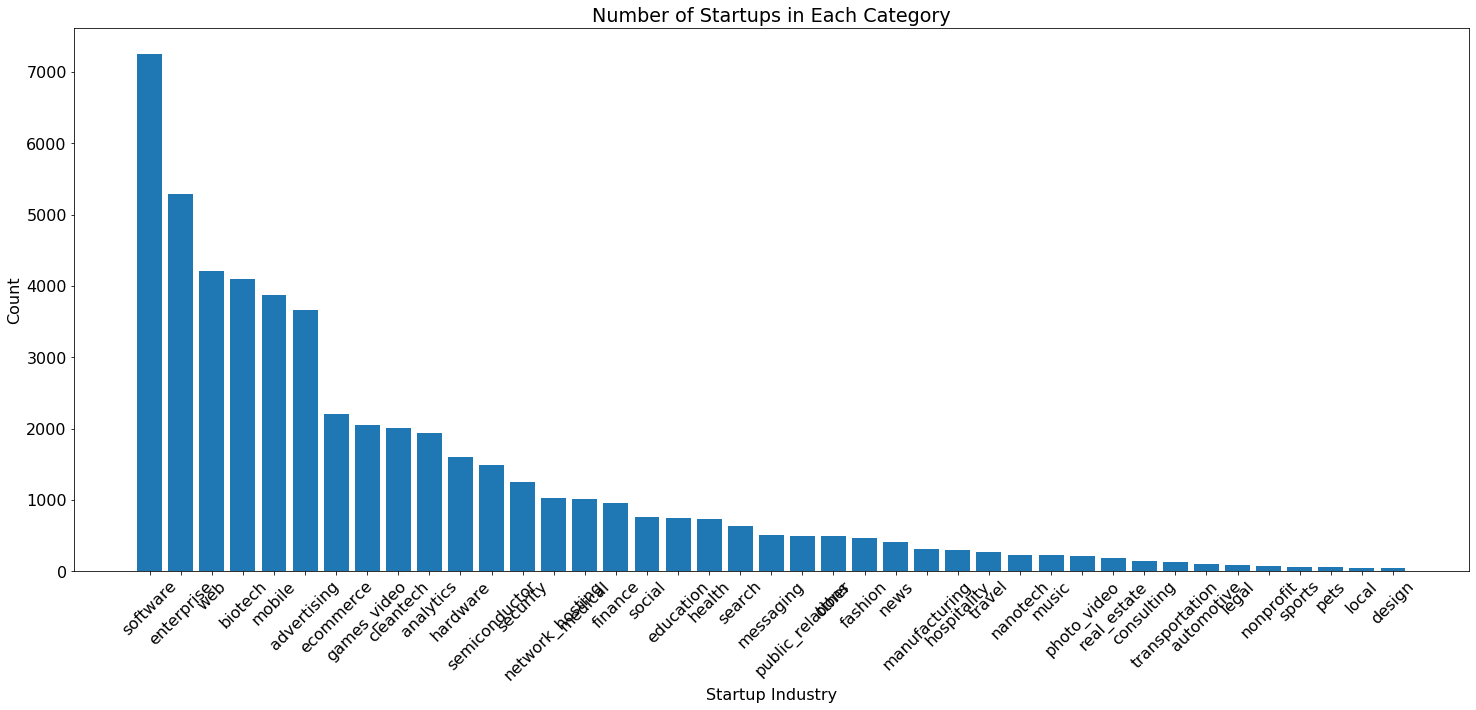

In [30]:
# insert graph showing how many companies in each category

plt.rcParams['figure.figsize'] = (25,10)

y = IF_filtered['category_code'].value_counts().tolist()
x = IF_filtered['category_code'].value_counts().index.tolist()
xarrange = np.arange(len(x))

plt.bar(xarrange,y)
plt.title('Number of Startups in Each Category')
plt.xlabel('Startup Industry')
plt.ylabel('Count')

plt.xticks(xarrange,x)
plt.xticks(rotation=45)
plt.xticks(fontsize=16)

plt.show()

Figure 6. This is the breakdown of industries the startups are classified as.

The following codes duplicate different data sets in order to be used for map building. I chose to do this to keep a clear and concise record of what I was doing in order to to keep the objects organized. 

In [31]:
duplicate_objects = objects.copy()
duplicate_objects.head()

,funded_object_id,entity_type,entity_id,parent_id,normalized_name,category_code,status,founded_at,closed_at,domain,...,region,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships
0,c:1,Company,1,NaN,wetpaint,web,operating,2005-10-17,NaN,wetpaint-inc.com,...,Seattle,NaN,NaN,0,0,2005-10-01,2008-05-19,3,39750000,17
1,c:1001,Company,1001,NaN,friendfeed,web,acquired,2007-10-01,NaN,friendfeed.com,...,SF Bay,NaN,NaN,0,0,2008-02-26,2008-02-26,1,5000000,14
2,c:10014,Company,10014,NaN,mobclix,mobile,acquired,2008-03-01,NaN,mobclix.com,...,SF Bay,NaN,NaN,0,0,2008-09-01,2008-09-01,1,0,9
3,c:10015,Company,10015,NaN,fitbit,health,operating,2007-10-01,NaN,fitbit.com,...,SF Bay,NaN,NaN,0,0,2008-10-10,2013-08-13,5,68069200,14
4,c:100155,Company,100155,NaN,mtpv,cleantech,operating,2003-01-01,NaN,mtpv.com,...,Austin,NaN,NaN,0,0,2011-03-08,2012-01-26,3,10125293,6


In [32]:
duplicate_funds.rename(columns={'investor_object_id':'funded_object_id'}, inplace=True)
#duplicate_funds.head()

In [33]:
ObjectFunds = duplicate_objects.merge(duplicate_funds,on='funded_object_id')
#ObjectFunds.head()

In [34]:
#IF_filtered['state_code'].value_counts()

THe following sections are the maps of where startups are in the US, followed by where the funds are in the US.

In [35]:
investorCC = ObjectFunds['country_code'].value_counts()
investorSC = IR_filtered['state_code'].value_counts()

### Startup Density With California Included

In [41]:
investorSC = IR_filtered['state_code'].value_counts().rename_axis('states').reset_index(name='count')
#print(investorSC.head)
data = dict(
        type = 'choropleth',
        colorscale = 'pinkyl',
        locations = investorSC['states'],
        locationmode = 'USA-states',
        z = investorSC['count'],
        colorbar = {'title' : 'Number of Startups'}
      )
layout = dict(
        title = '2013 Startups by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
chloromap = go.Figure(data = data, layout=layout)
iplot(chloromap)

Figure 7. This is the startup count among the US States. California has an overwhelming majority, followed by the Northeast and Texas and Washington after that.

### Startup Density Without California Included

In [43]:
IR_filtered_noCA = IR_filtered[IR_filtered['state_code'] != 'CA'] 
IR_filtered_noCA['state_code'].value_counts()

startups_noCA = IR_filtered_noCA['state_code'].value_counts().rename_axis('states').reset_index(name='count')
#print(investorSC.head)
data = dict(
        type = 'choropleth',
        colorscale = 'pinkyl',
        locations = startups_noCA['states'],
        locationmode = 'USA-states',
        z = startups_noCA['count'],
        colorbar = {'title' : 'Number of Startups'}
      )
layout = dict(
        title = '2013 Startups by State<br>(Hover for breakdown)<br>(not including CA)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
chloromap = go.Figure(data = data, layout=layout)
iplot(chloromap)

Figure 8. Geographic distribution of startups, not including California.

### Investor Density With California Included

In [38]:
investorLocations_filtered = ObjectFunds[ObjectFunds['country_code'] == 'USA'] 
#investorLocations_filtered['state_code'].value_counts()

In [39]:
investorLocation = investorLocations_filtered['state_code'].value_counts().rename_axis('states').reset_index(name='count')
#print(investorLocation.head)
data = dict(
        type = 'choropleth',
        colorscale = 'greens',
        locations = investorLocation['states'],
        locationmode = 'USA-states',
        z = investorLocation['count'],
        colorbar = {'title' : 'Number of Funds'}
      )
layout = dict(
        title = '2013 Funding Entities by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
chloromap = go.Figure(data = data, layout=layout)
iplot(chloromap)

Figure 9. Geographic distribution of Funds, including California.

### Investor Density Without California Included

In [40]:
investorLocations_noCA = ObjectFunds[ObjectFunds['state_code'] != 'CA'] 
investorLocations_noCA['state_code'].value_counts()


investorLocation_noCA = investorLocations_noCA['state_code'].value_counts().rename_axis('states').reset_index(name='count')
#print(investorLocation.head)
data = dict(
        type = 'choropleth',
        colorscale = 'greens',
        locations = investorLocation_noCA['states'],
        locationmode = 'USA-states',
        z = investorLocation_noCA['count'],
        colorbar = {'title' : 'Number of Funds'}
      )
layout = dict(
        title = '2013 Funding Entities by State<br>(Hover for breakdown)<br>(California not included)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )
chloromap = go.Figure(data = data, layout=layout)
iplot(chloromap)

Figure 10. Geographic distribution of funds, not including California.